In [2]:
import sys
import os
sys.path.append("../..")

from progressbar import progressbar as pbar
from omegaconf import OmegaConf
from sdofm.datasets.SDOML import SDOMLDataModule, SDOMLDataset
from sdofm.datasets.RandomIntervalSDOML import RandomIntervalSDOMLDataset, RandomIntervalSDOMLDataModule 
from sdofm.models.rotation import RotationEstimator
from rlxutils import subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sdofm.utils import stonyhurst_to_patch_index
from progressbar import progressbar as pbar
from sdofm.constants import ALL_COMPONENTS, ALL_WAVELENGTHS, ALL_IONS
from rlxutils import ElapsedTimes
import torch
from torch import nn
from sdofm.models import unet
import torch.nn.functional as F


In [3]:
cfg = OmegaConf.load("../../experiments/default.yaml")

In [4]:
year = '2014'
year_end = year
year_start = year
data_module = RandomIntervalSDOMLDataModule(
    # hmi_path=os.path.join(
    #     self.cfg.data.sdoml.base_directory, self.cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.hmi,
    ),
    aia_path = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),    
    eve_path = None,
    components  = cfg.data.sdoml.components,
    wavelengths = cfg.data.sdoml.wavelengths,
    ions        = cfg.data.sdoml.ions,
    frequency   = cfg.data.sdoml.frequency,
    batch_size  = 2,
    num_workers = 10,
    num_frames  = 2,
    blosc_cache = "/home/rlx/blosc_cache",
    start_date = f'{year_start}-01-01',
    end_date   = f'{year_end}-12-31',
    dim = False,
    sampling_period = '10days',
    val_months  = cfg.data.month_splits.val,
    test_months = cfg.data.month_splits.test,
    holdout_months = cfg.data.month_splits.holdout,
    cache_dir = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_HMI_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_HMI_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [4]:
dltrain = data_module.train_dataloader()
train_iter = iter(dltrain)

In [109]:
b = next(train_iter)
b['timestamps']

[('2014-07-15 22:36:00', '2014-07-03 02:24:00'),
 ('2014-07-22 17:24:00', '2014-07-05 04:48:00')]

In [110]:
b['image_stack'].shape

torch.Size([2, 12, 2, 512, 512])

In [42]:
#model = torch.load(f"unet_pretrained_rotation_estimator_{year}.ckpt")
model = torch.load(f"scratch_rotation_estimator_{year}.ckpt")

# build dataloader objects

In [55]:
def batch_predict_viz(model):
    dataloader = data_module.test_dataloader()
    for batch in pbar(dataloader, max_value=len(dataloader)):
        if np.random.rand()>.995:
            break

    # extract data from batch
    n = len(batch['image_stack'])

    # assumes two timeframes, compute actual time between both timeframes and scales it
    # wrt to the sampling period so that it is in [0,1]
    t = batch['timestamps']
    tdeltas_truth = torch.tensor([(pd.Timestamp(t[1][ni])-pd.Timestamp(t[0][ni]))/pd.Timedelta(data_module.sampling_period) \
                                  for ni in range(n)])\
                               .reshape(-1,1)


    image_stack_t0 = batch['image_stack'][:,:,0,:,:].cuda()
    image_stack_t1 = batch['image_stack'][:,:,1,:,:].cuda()

    enc0 = model.unet.forward_encode(image_stack_t0).detach().cpu().numpy()
    enc1 = model.unet.forward_encode(image_stack_t1).detach().cpu().numpy()

    t = batch['timestamps']

    img0 = image_stack_t0.cpu().numpy()
    img1 = image_stack_t1.cpu().numpy()

    tdeltas_truth = torch.tensor([(pd.Timestamp(t[1][ni])-pd.Timestamp(t[0][ni]))/pd.Timedelta(data_module.sampling_period) \
                                  for ni in range(n)])\
                               .reshape(-1,1)\
                               .cpu().detach().numpy()
    tdeltas_pred = model(image_stack_t0, image_stack_t1).cpu().detach().numpy()


    for idx in range (len(tdeltas_truth)):

        timedelta_target = pd.Timedelta(data_module.sampling_period) * float(tdeltas_truth[idx][0])
        timedelta_pred   = pd.Timedelta(data_module.sampling_period) * float(tdeltas_pred[idx][0])
        timedelta_error = timedelta_pred - timedelta_target 
        rmse = np.sqrt( (tdeltas_truth[idx][0] - tdeltas_pred[idx][0])**2)

        for (enc,img, timestamp) in [(enc0, img0, batch['timestamps'][0][idx]), (enc1, img1, batch['timestamps'][1][idx])]:
            for ax,i in subplots(6):
                if i==0:
                    x = img[idx, 6]
                    if enc is enc1:
                        prederror_str = f"prediction error {rmse:.3f} =\n {timedelta_error.days} days {np.round(timedelta_error.seconds/60/60,2)} hours"
                        predicted = (pd.Timestamp(timestamp) + timedelta_pred).strftime("%Y-%m-%d %H:%M:%S")
                        predicted_str = f"pred {predicted}"
                        plt.title(f"T1:   {timestamp}\n{predicted_str}")
                    else:
                        plt.title(f"T0:   {timestamp}")

                else:
                    x = enc[idx,i-1]
                    plt.title(f"encoding {i-1}/{enc[idx].shape[0]}")



                a,b = np.percentile(x, [1,99])
                plt.imshow(x, vmin=a, vmax=b)
                plt.axis("off")

 20% (183 of 906) |####                  | Elapsed Time: 0:00:21 ETA:   0:01:26

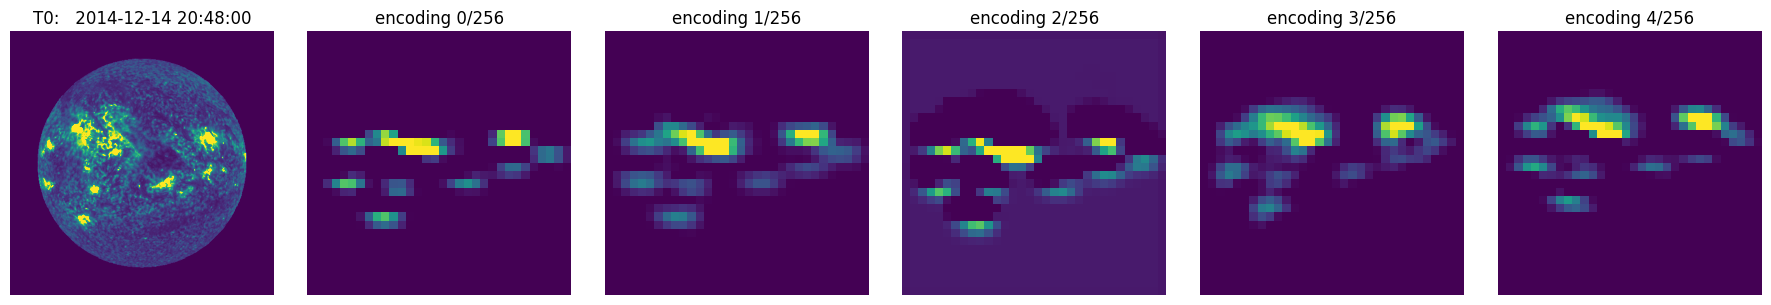

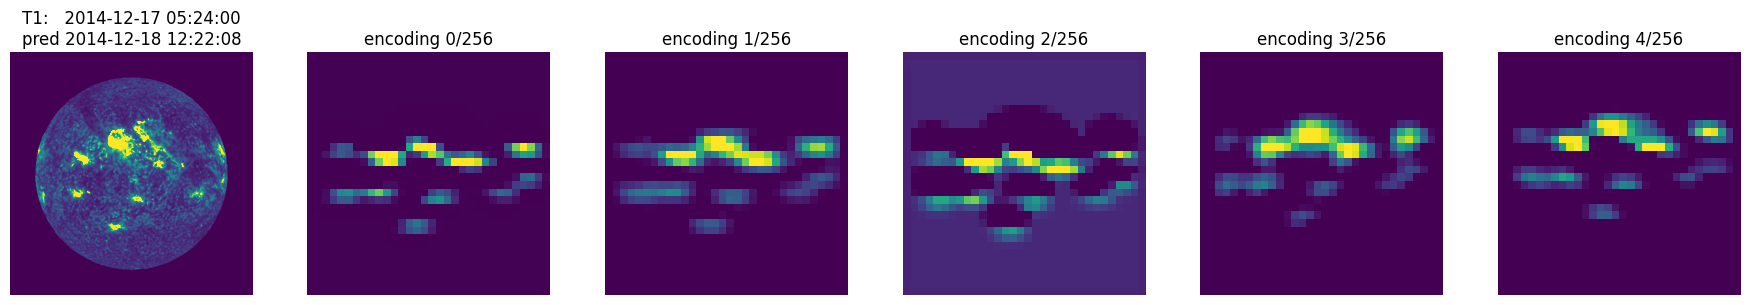

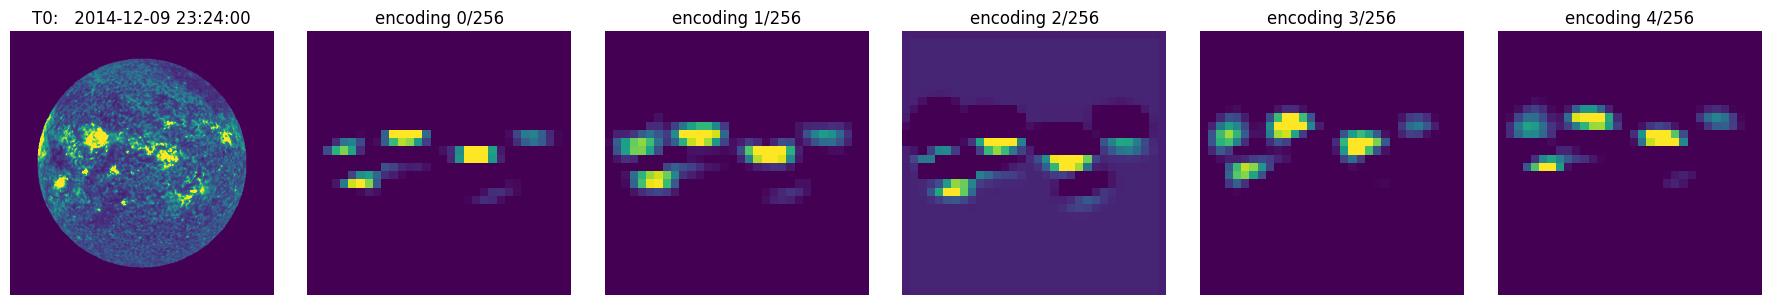

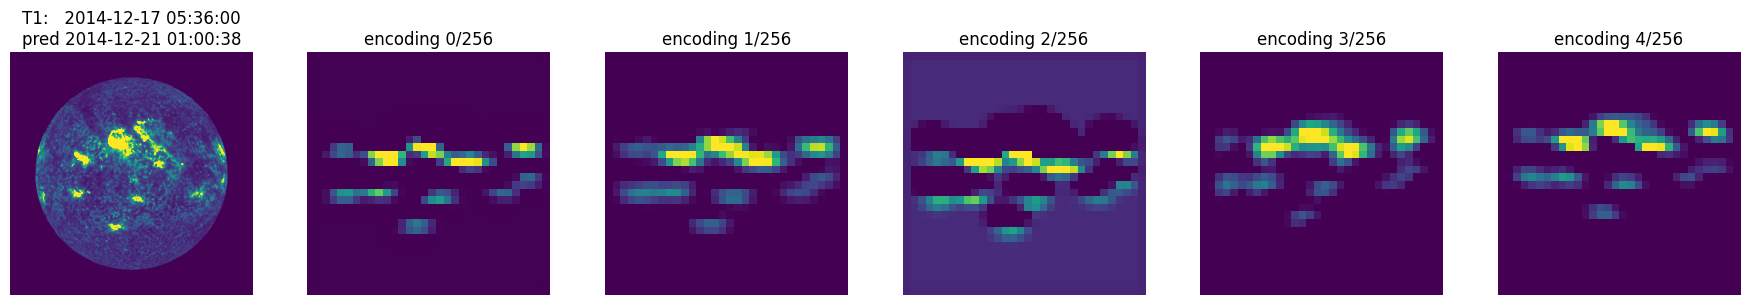

In [56]:
batch_predict_viz(model_scratch)

 13% (126 of 906) |###                   | Elapsed Time: 0:00:13 ETA:   0:01:20

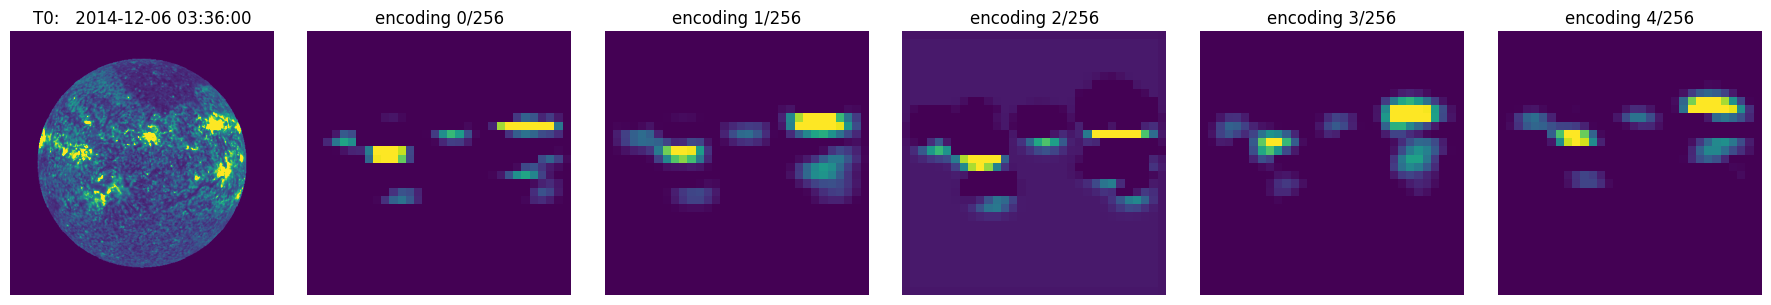

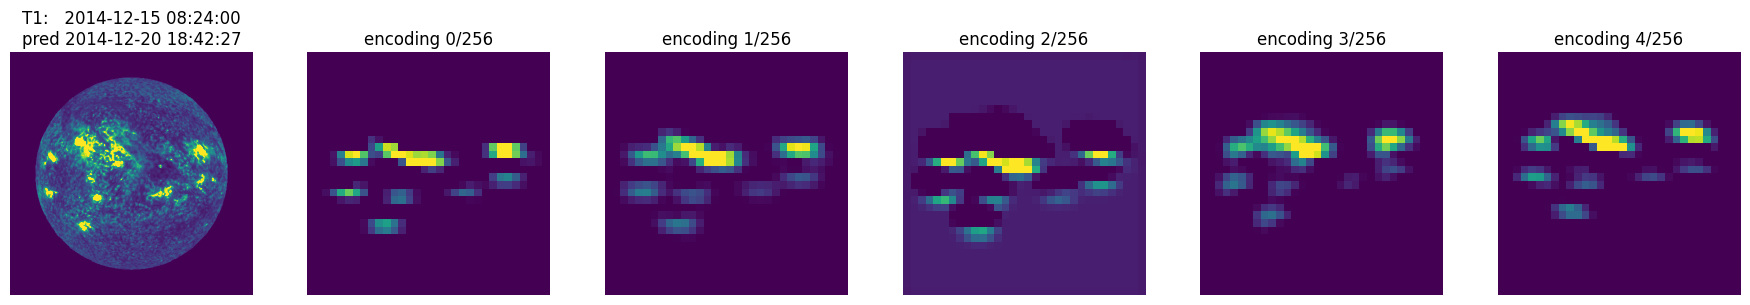

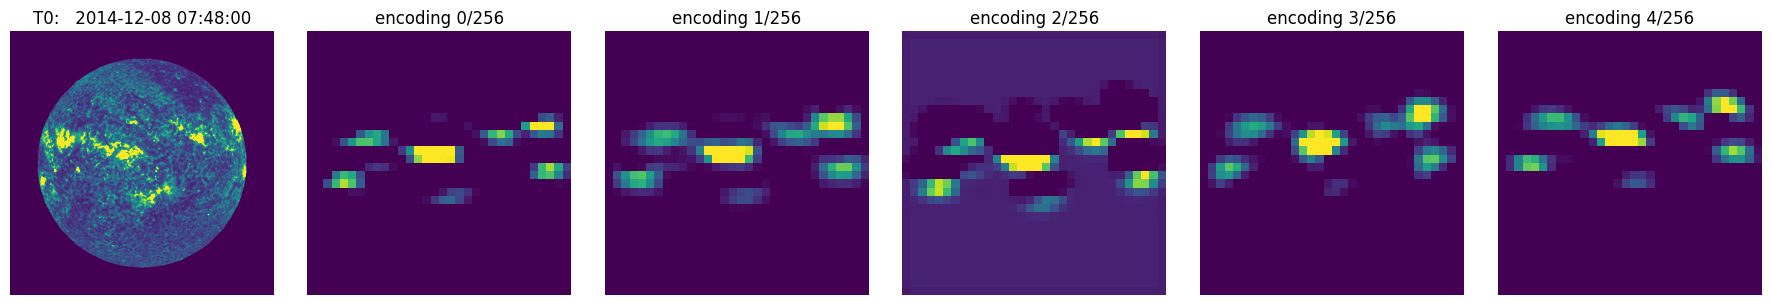

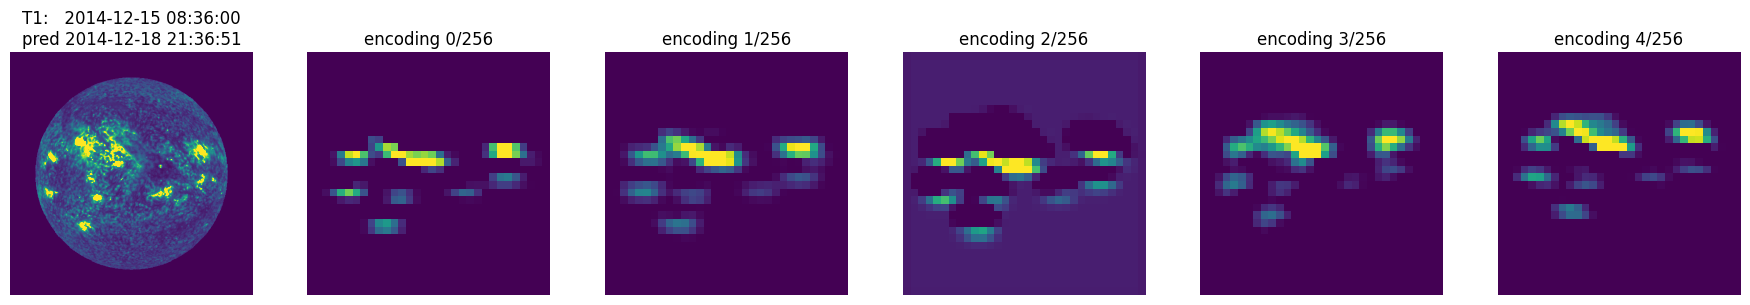

In [57]:
batch_predict_viz(model_scratch)

In [141]:

enc0 = model.unet.forward_encode(image_stack_t0).detach().cpu().numpy()
enc1 = model.unet.forward_encode(image_stack_t1).detach().cpu().numpy()
enc0.shape, enc1.shape

((2, 256, 32, 32), (2, 256, 32, 32))

In [1]:
t = batch['timestamps']

img0 = image_stack_t0.cpu().numpy()
img1 = image_stack_t1.cpu().numpy()

tdeltas_truth = torch.tensor([(pd.Timestamp(t[1][ni])-pd.Timestamp(t[0][ni]))/pd.Timedelta(data_module.sampling_period) \
                              for ni in range(n)])\
                           .reshape(-1,1)\
                           .cpu().detach().numpy()
tdeltas_pred = model(image_stack_t0, image_stack_t1).cpu().detach().numpy()
tdeltas_truth, tdeltas_pred

NameError: name 'batch' is not defined

In [138]:
batch['timestamps'][0]

('2014-11-09 15:36:00', '2014-11-09 08:12:00')

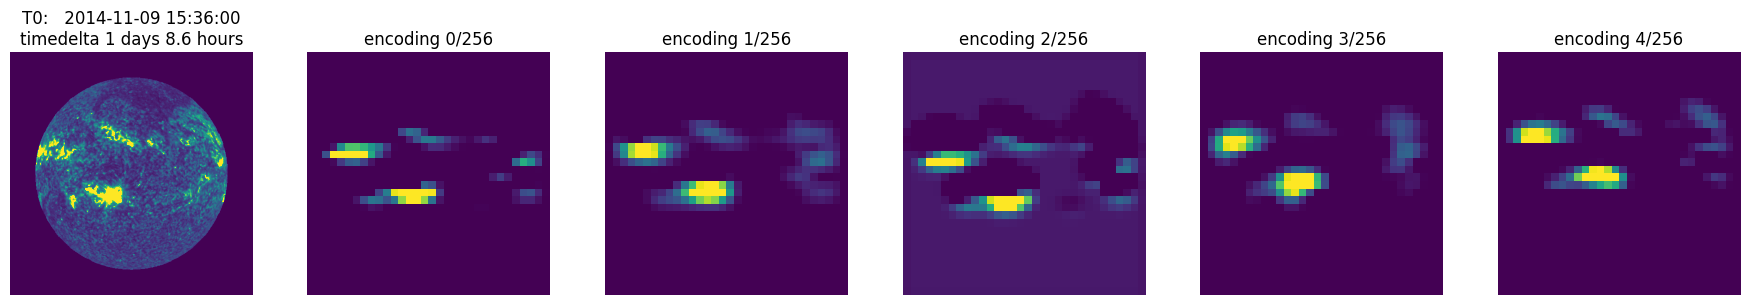

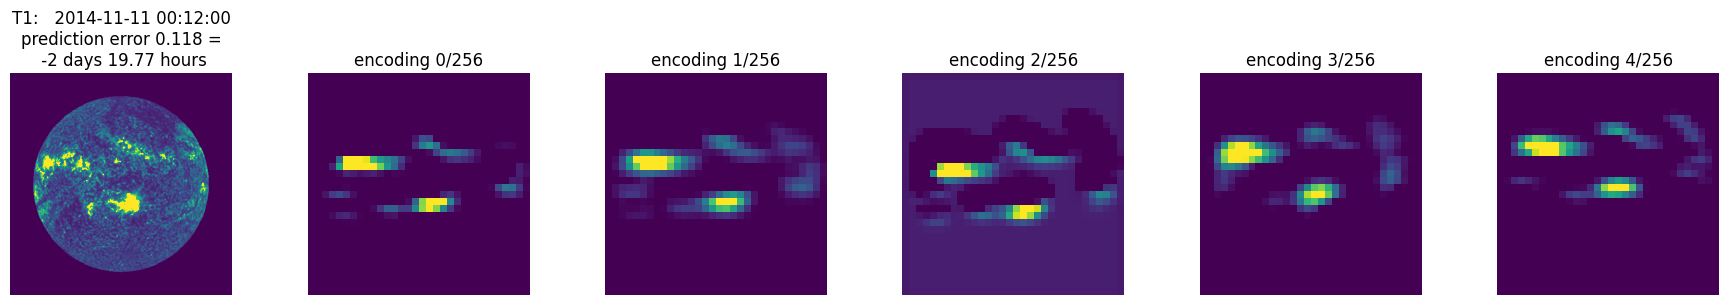

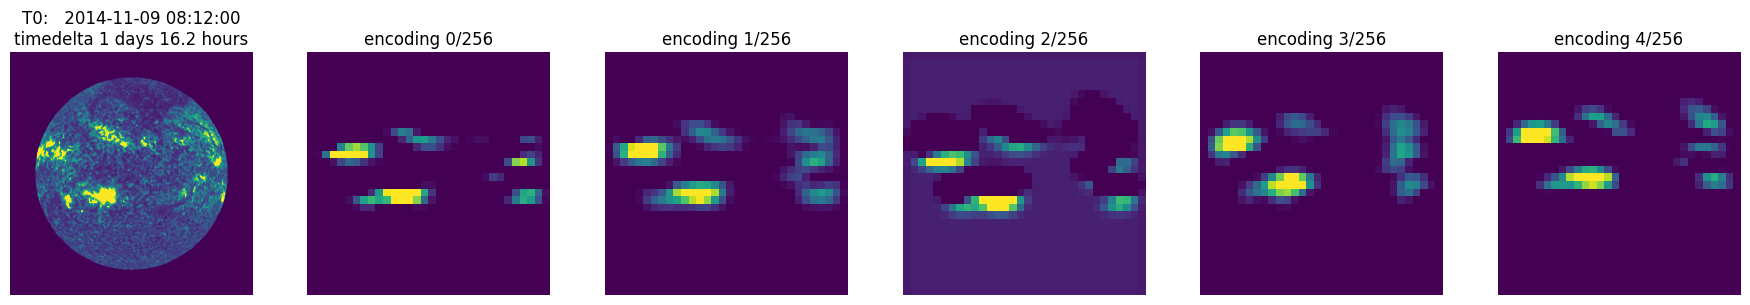

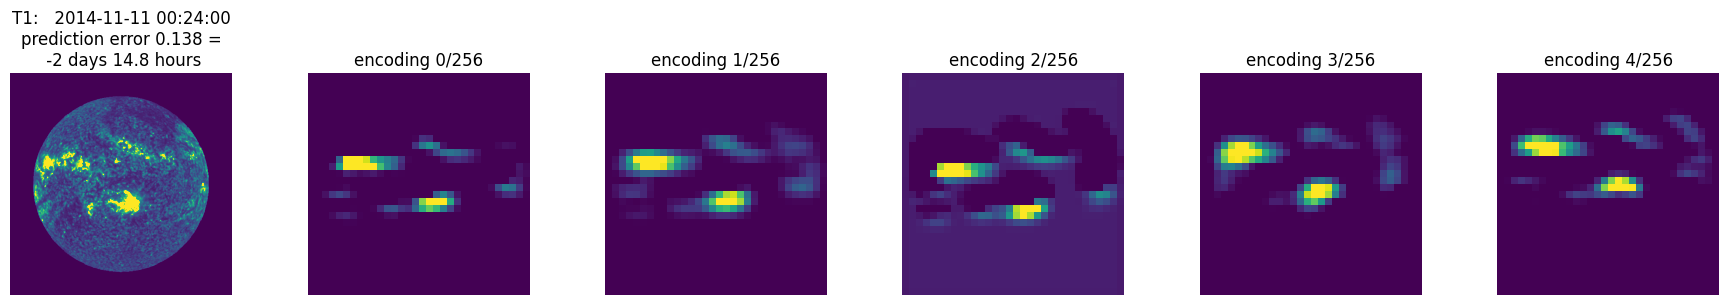

In [139]:

for idx in range (len(tdeltas_truth)):

    timedelta_target = pd.Timedelta(data_module.sampling_period) * float(tdeltas_truth[idx][0])
    timedelta_pred   = pd.Timedelta(data_module.sampling_period) * float(tdeltas_pred[idx][0])
    timedelta_error = timedelta_pred - timedelta_target 
    rmse = np.sqrt( (tdeltas_truth[idx][0] - tdeltas_pred[idx][0])**2)

    for (enc,img, timestamp) in [(enc0, img0, batch['timestamps'][0][idx]), (enc1, img1, batch['timestamps'][1][idx])]:
        for ax,i in subplots(6):
            if i==0:
                x = img[idx, 6]
                if enc is enc1:
                    prederror_str = f"prediction error {rmse:.3f} =\n {timedelta_error.days} days {np.round(timedelta_error.seconds/60/60,2)} hours"
                    plt.title(f"T1:   {timestamp}\n{prederror_str}")
                else:
                    timedelta_str = f"timedelta {timedelta_target.days} days {np.round(timedelta_target.seconds/60/60,2)} hours"
                    plt.title(f"T0:   {timestamp}\n{timedelta_str}")

            else:
                x = enc[idx,i-1]
                plt.title(f"encoding {i-1}/{enc[idx].shape[0]}")



            a,b = np.percentile(x, [1,99])
            plt.imshow(x, vmin=a, vmax=b)
            plt.axis("off")

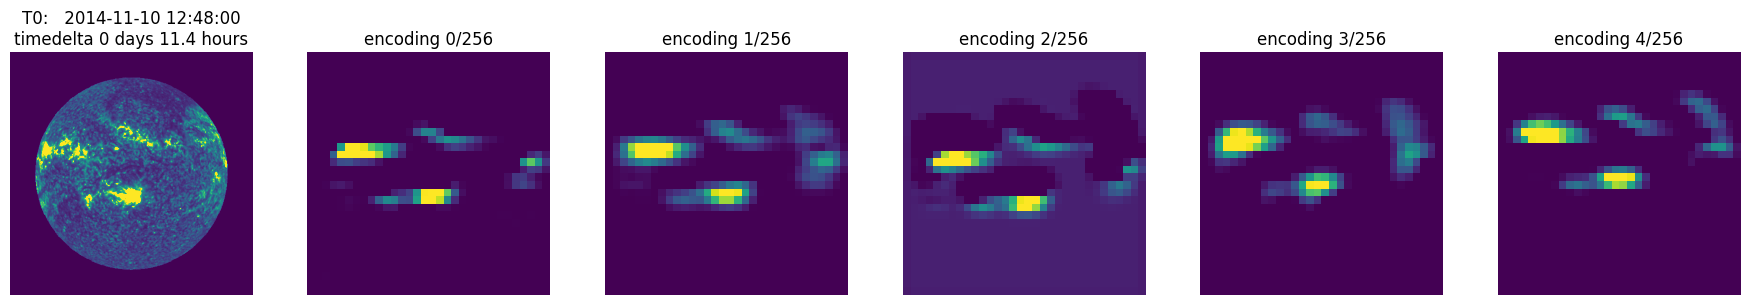

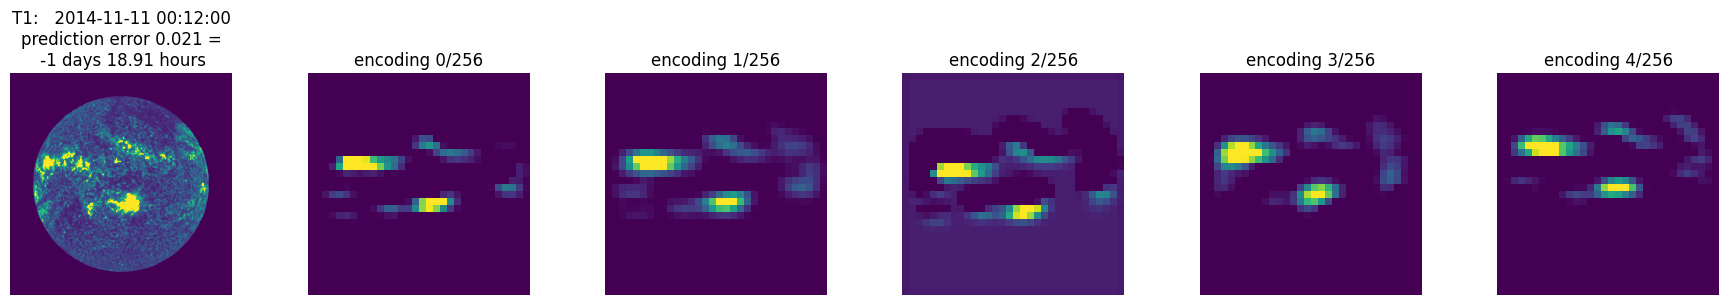

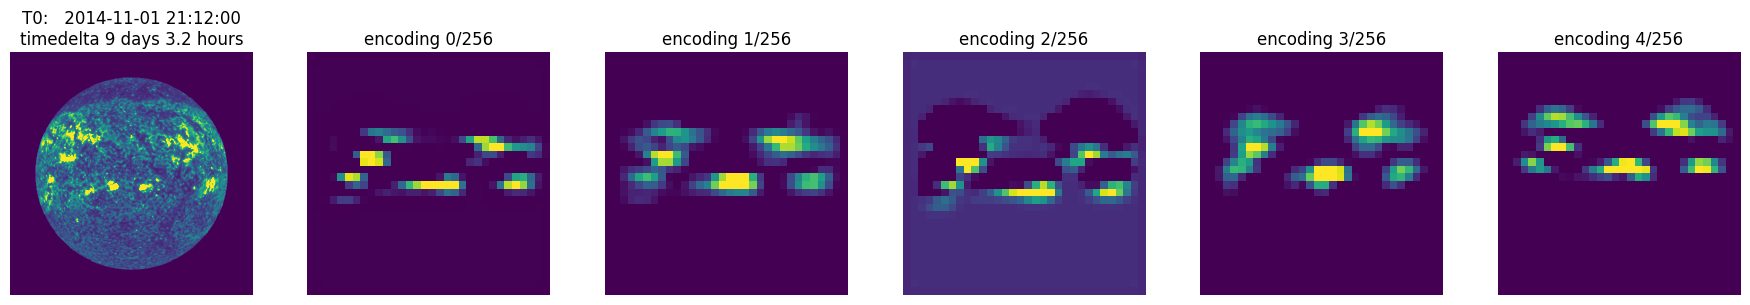

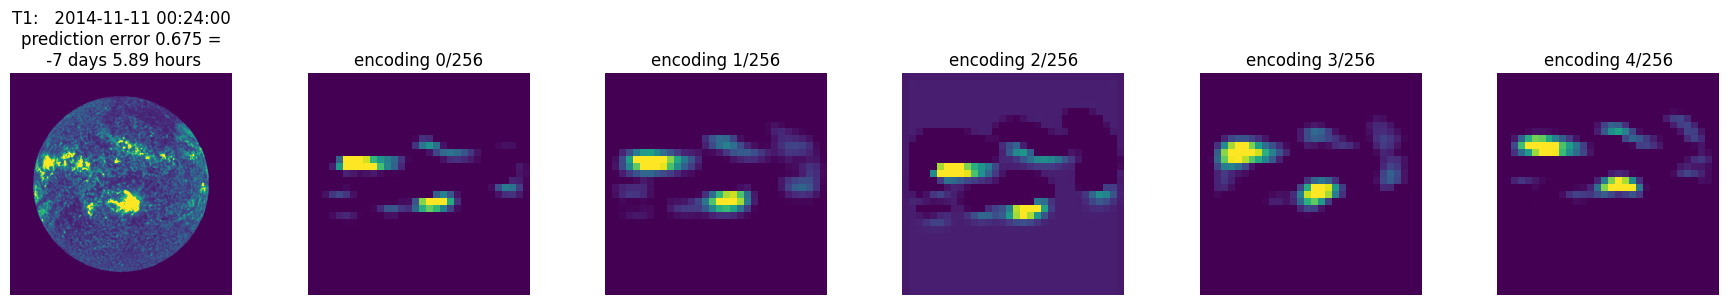

In [119]:
idx = 0

for idx in range (len(tdeltas_truth)):

    timedelta_target = pd.Timedelta(data_module.sampling_period) * float(tdeltas_truth[idx][0])
    timedelta_pred   = pd.Timedelta(data_module.sampling_period) * float(tdeltas_pred[idx][0])
    timedelta_error = timedelta_pred - timedelta_target 
    rmse = np.sqrt( (tdeltas_truth[idx][0] - tdeltas_pred[idx][0])**2)

    for (enc,img, timestamp) in [(enc0, img0, batch['timestamps'][0][idx]), (enc1, img1, batch['timestamps'][1][idx])]:
        for ax,i in subplots(6):
            if i==0:
                x = img[idx, 6]
                if enc is enc1:
                    prederror_str = f"prediction error {rmse:.3f} =\n {timedelta_error.days} days {np.round(timedelta_error.seconds/60/60,2)} hours"
                    plt.title(f"T1:   {timestamp}\n{prederror_str}")
                else:
                    timedelta_str = f"timedelta {timedelta_target.days} days {np.round(timedelta_target.seconds/60/60,2)} hours"
                    plt.title(f"T0:   {timestamp}\n{timedelta_str}")

            else:
                x = enc[idx,i-1]
                plt.title(f"encoding {i-1}/{enc[idx].shape[0]}")



            a,b = np.percentile(x, [1,99])
            plt.imshow(x, vmin=a, vmax=b)
            plt.axis("off")


In [92]:
timedelta_target, timedelta_pred

(Timedelta('1 days 06:11:59.999313354'),
 Timedelta('0 days 16:59:53.034410476'))

In [93]:
tdeltas_pred

array([[0.07082527],
       [0.03136507]], dtype=float32)

In [94]:
tdeltas_truth

array([[0.12583333],
       [0.05166667]], dtype=float32)

In [48]:
timedelta_target = pd.Timedelta(data_module.sampling_period) * float(tdeltas_truth[idx][0])
timedelta_pred   = pd.Timedelta(data_module.sampling_period) * float(tdeltas_pred[idx][0])
timedelta_error = timedelta_target - timedelta_pred


In [57]:
f"prediction error {timedelta_error.days} days {np.round(timedelta_error.seconds/60/60,2)} hours"

'prediction error 0 days 11.46 hours'

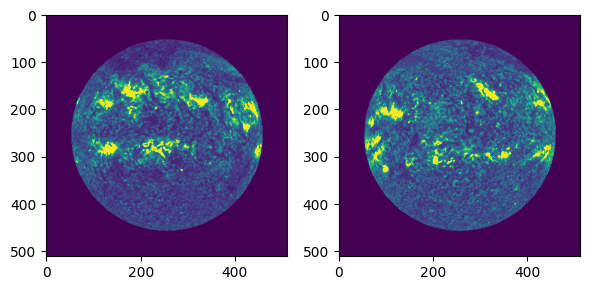

In [19]:
t0 = image_stack_t0.cpu().numpy()
t1 = image_stack_t1.cpu().numpy()
for ax, i in subplots(2):
    if i==0:
        x = t0[idx, 6]
    if i==1:
        x = t1[idx, 6]
    
    a,b=np.percentile(x, [1,99])
    plt.imshow(x, vmin=a, vmax=b)
    plt.imshow(x, vmin=a, vmax=b)

In [157]:
[i[idx] for i in batch['timestamps']]

['2014-08-23 16:00:00', '2014-08-28 10:48:00']